In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import pennylane as qml
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [5]:
image_size = (64, 64)  # Resize from 450x450 to 64x64
batch_size = 32  

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "major_dataset",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="int"  # Binary labels (Healthy=0, Diseased=1)
)


Found 4000 files belonging to 2 classes.


In [6]:
# Define paths
val_data_path = "Dataset/validation_data/validation/"
val_csv_path = "Dataset/validation_data/C-NMC_test_prelim_phase_data_labels.csv"

# Load labels from CSV
val_labels_df = pd.read_csv(val_csv_path)

# Convert labels to dictionary {filename: label}
val_labels_dict = dict(zip(val_labels_df["new_names"], val_labels_df["labels"]))

print("✅ Validation Labels Loaded Successfully!")

# Load Validation Images & Assign Labels
val_images, val_labels = [], []

for img_name in os.listdir(val_data_path):
    if img_name in val_labels_dict:  # Only process images in CSV
        img_path = os.path.join(val_data_path, img_name)
        img = load_img(img_path, target_size=image_size)  # Resize
        img = img_to_array(img) / 255.0  # Normalize
        val_images.append(img)
        val_labels.append(val_labels_dict[img_name])  # Get label

val_images = np.array(val_images)
val_labels = np.array(val_labels)

print(f"✅ Total Validation Images: {len(val_images)}")


✅ Validation Labels Loaded Successfully!
✅ Total Validation Images: 1867


In [5]:
test_images = []

for img_name in os.listdir("Dataset/testing/"):
    if img_name.endswith(".bmp") or img_name.endswith(".png"):
        img_path = os.path.join("Dataset/testing", img_name)
        img = load_img(img_path, target_size=image_size)
        img = img_to_array(img) / 255.0
        test_images.append(img)

test_images = np.array(test_images)
print(f"✅ Total Test Images: {len(test_images)}")


✅ Total Test Images: 2586


In [7]:
import pennylane as qml
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer

# Define Quantum Device (2 Qubits)
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))  # Convert features to quantum states
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))  # Quantum Processing
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]  # Measurement


In [8]:
class QuantumLayer(Layer):
    def __init__(self, weight_shapes, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.weight_shapes = weight_shapes
        self.kernel = self.add_weight(
            shape=weight_shapes["weights"],
            initializer="random_normal",
            trainable=True
        )

    def call(self, inputs):
        def circuit_wrapper(input_np, kernel_np):
            output = quantum_circuit(input_np, kernel_np)
            return tf.convert_to_tensor(output, dtype=tf.float32)

        # Use tf.py_function to integrate Quantum Circuit with TensorFlow
        output = tf.py_function(func=circuit_wrapper, inp=[inputs, self.kernel], Tout=tf.float32)

        # 🔹 Ensure correct shape (batch_size, 2)
        output = tf.reshape(output, (-1, 2))  
        
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2)  # 🔹 Ensure correct tensor size


In [9]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),  # 🔹 Ensure correct feature size before QNN
    layers.Dense(2, activation='linear')  # 🔹 Output 2 features for QNN
])


C:\Users\aruna\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras import Model, Input

# Define Quantum Layer
quantum_layer = QuantumLayer({"weights": (3, n_qubits, 3)})

# Define Input Layer
inputs = Input(shape=(64, 64, 3))

# CNN Feature Extraction
cnn_features = cnn_model(inputs)t

# Quantum Processing
quantum_outputs = quantum_layer(cnn_features)

# 🔹 Correct Final Dense Layer (Avoid Shape Mismatch)
outputs = layers.Dense(2, activation="softmax")(quantum_outputs)

# Build Model
model = Model(inputs=inputs, outputs=outputs)

# Compile Model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [11]:
history=model.fit(train_ds, validation_data=(val_images, val_labels), epochs=2)


Epoch 1/2
  1/125 ━━━━━━━━━━━━━━━━━━━━ 6:25 3s/step - accuracy: 0.4062 - loss: 0.7423WARNING:tensorflow:You are casting an input of type complex128 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.
  2/125 ━━━━━━━━━━━━━━━━━━━━ 54s 440ms/step - accuracy: 0.4219 - loss: 0.7433WARNING:tensorflow:You are casting an input of type complex128 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.
  3/125 ━━━━━━━━━━━━━━━━━━━━ 51s 420ms/step - accuracy: 0.4271 - loss: 0.7450WARNING:tensorflow:You are casting an input of type complex128 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.
  4/125 ━━━━━━━━━━━━━━━━━━━━ 50s 417ms/step - accuracy: 0.4297 - loss: 0.7450WARNING:tensorflow:You are casting an input of type complex128 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.
  5/125 

In [24]:
test_acc, test_loss = model.evaluate(train_ds, verbose=0)


In [32]:
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")

✅ Test Accuracy: 94.35%


In [22]:
model.save('my_model2.h5')  # Save as HDF5 file


In [12]:
model.export("saved_model_qnn")


INFO:tensorflow:Assets written to: saved_model_qnn\assets


INFO:tensorflow:Assets written to: saved_model_qnn\assets


Saved artifact at 'saved_model_qnn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2987977931088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2987977932048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2987977930896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2987977932624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2987977929936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2987977931280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2987977932240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2987977932432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2987977931472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2987980736080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2987977930704: TensorSpec(shape=()

In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pennylane as qml
from tensorflow.keras.layers import Layer

In [12]:
# Preprocessing function
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((64, 64))
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Prediction function
def predict_image(image_path):
    image_tensor = preprocess_image(image_path)
    prediction = model.predict(image_tensor)
    predicted_class = int(np.argmax(prediction))

    result = "Healthy" if predicted_class == 0 else "Diseased"
    precautions = {
        "Healthy": "🟢 You appear healthy. Maintain regular checkups.",
        "Diseased": "🔴 Signs of ALL detected. Please consult a hematologist immediately."
    }

    print("Prediction:", result)
    print("Precaution:", precautions[result])


    

In [14]:
test_image_path = r"D:/major/Leukemia/Dataset/Training/hel/UID_H1_6_1_hem.bmp" # Replace with your image path
predict_image(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Prediction: Healthy
Precaution: 🟢 You appear healthy. Maintain regular checkups.


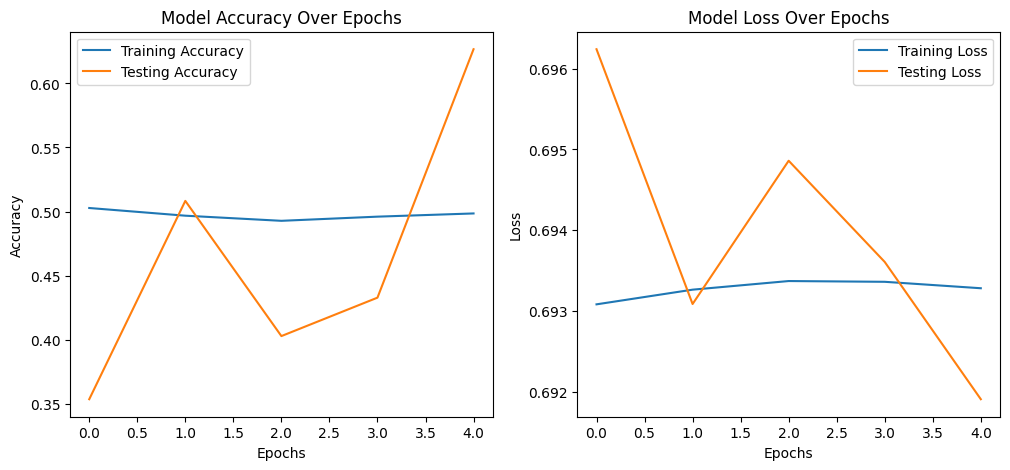

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')

plt.show()


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [34]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable


In [36]:
# Get predicted class indices
y_pred_probs = model.predict(val_images)
y_pred = np.argmax(y_pred_probs, axis=1)  # For multiclass

# If it's binary classification with sigmoid output:
# y_pred = (y_pred_probs > 0.5).astype("int")


59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step


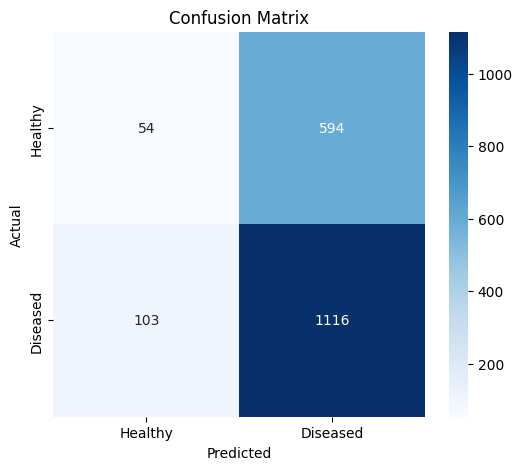

In [37]:
cm = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Diseased'], yticklabels=['Healthy', 'Diseased'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [39]:
import numpy as np

y_true = []
y_pred = []

for images, labels in train_ds:  # or test_ds if you have it
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)  # get predicted class
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1

In [41]:

class_names = train_ds.class_names  # or test_ds.class_names if you're using test data


In [43]:
# Get predictions from model
y_pred_probs = model.predict(val_images)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ground truth labels (already created earlier)
y_true = val_labels


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


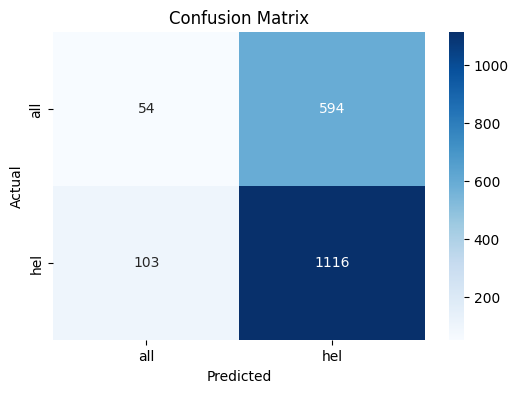

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = train_ds.class_names  # ['Healthy', 'Diseased'] or your own labels

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report


classification_report=classification_report(y_true, y_pred, target_names=class_names)


In [3]:
print(classification_report)


Classification Report:

              precision    recall  f1-score   support

         all       0.93      0.94      0.93       648
         hel       0.95      0.95      0.95      1219

    accuracy                           0.94      1867
   macro avg       0.94      0.94      0.94      1867
weighted avg       0.94      0.94      0.94      1867



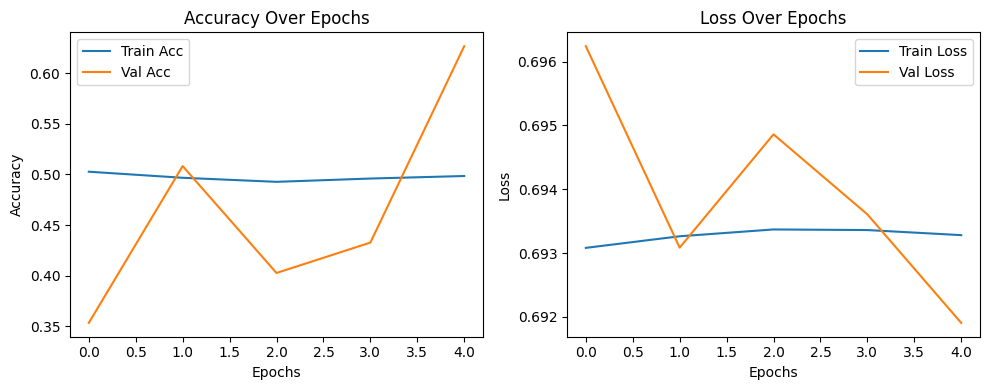

In [46]:
# history = model.fit(...) earlier

plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


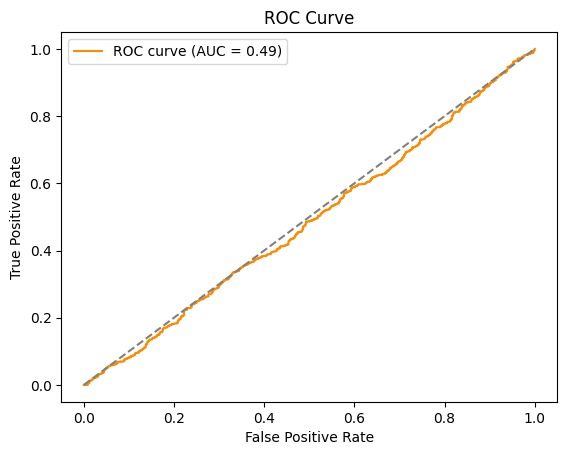

In [47]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])  # Class 1 probabilities
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


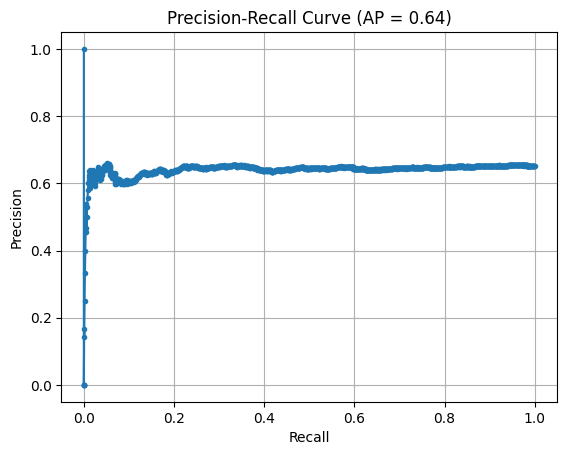

In [48]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_pred_probs[:, 1])
ap_score = average_precision_score(y_true, y_pred_probs[:, 1])

plt.plot(recall, precision, marker='.')
plt.title(f'Precision-Recall Curve (AP = {ap_score:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()
